# Classificador Fuzzy X Redes Neurais

<a id="topo"></a>
# Sumário

1. [Dados](#dados)  
2. [Fuzzy](#fuzzy)  
    2.1 [Base de dados](#bdfuzzy)  
    2.2 [Base de regras](#brfuzzy)  
    2.3 [Treinamento](#treinamentofuzzy)  
    2.4 [Teste](#testefuzzy)  
    2.5 [Concluões](#conclufuzzy)  
3. [Rede Neural](#rn)  
    3.1 [Modelagem](#modelagemrn)  
    3.3 [Treinamento](#treinamentorn)  
    3.4 [Teste](#testern)  
    3.5 [Concluões](#conclurn)  
4. [Considerações Finais](#conclufinal)


Este trabalho tem por objetivo realizar a comparação entre um Classificador Fuzzy e Rede Neural para a tarefa de verificação de autenticidade de cédulas monetárias.  
![cedula](cedula.png)

<a id="dados"></a>
## Dados
<div style="text-align: right"> [TOPO](#topo) </div>

Dada uma imagem de uma cédula é obtida realiza-se a transformada Wavelet desta para obter os seguintes parâmetros:  
- variance
- skewness
- curtosis
- entropy

Guarda-se esses parâmetros juntamente com um valor de saída, definindo se a célula é autêntica(0) ou falsificada(1).  
Sendo assim, cada tupla de dados fica da seguinte forma: **(variance, skewness, curtosis, entropy, saida)**  

Um conjunto de dados nesse formato foi diponibilizado no arquivo **dados_autent_bancaria.txt** para ser utilizado nos algoritmos que este trabalho visa tratar.

<a id="fuzzy"></a>
## Fuzzy

<a id="bdfuzzy"></a>
### Base de dados
<div style="text-align: right"> [TOPO](#topo) </div>

O primeiro passo para realizar a classificação utilizando fuzzy é particionar o universo das variaveis.Sendo assim iremos importar os dados disponíveis.

In [ ]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

#importando dados
my_data = np.genfromtxt('dados_autent_bancaria.txt', delimiter=',')
variance_data = my_data[:,0]
skewness_data = my_data[:,1]
curtosis_data = my_data[:,2]
entropy_data = my_data[:,3]
classif_data = my_data[:,4]


Logo após definimos o universo de discurso de cada uma das variáveis do problema. Definiu-se um offset de 2 unidades para cada variável para poder ter uma margem quando o dado estivesse nos extremos. Também definiu-se uma precisão de 2 casas decimais.

In [ ]:
offset = 1    #offset para os valores importados

#Universo das variáveis
variance = np.arange(int(min(variance_data)-offset), int(max(variance_data)+offset), 0.01)
skewness = np.arange(int(min(skewness_data)-offset), int(max(skewness_data)+offset), 0.01)
curtosis = np.arange(int(min(curtosis_data)-offset), int(max(curtosis_data)+offset), 0.01)
entropy = np.arange(int(min(entropy_data)-offset), int(max(entropy_data)+offset), 0.01)
classif = np.arange(0-0.2, 1+0.2, 0.01)


Tendo o universo de discurso definido, é possível gerar as variáveis linguisticas fuzzy, que nada mais são do que funções de associação(*membership fuction*). Este é um passo importante pois é onde discretiza-se o universo de discurso em conjuntos fuzzy. Primeio pois é necessário ter um conhecimento previo sobre as variáveis para poder separar as classes/niveis de forma coerente e um maior numero de variáveis implica em um numero maior de regras.  

Para particionar universo, optou-se pela abordagem **uniforme** onde o universo da variavel será dividido em 4 partes, ou seja, cada variável terá um funcao baixa(lo), média baixa(ml), média alta(mh) e alta(hi). Cada uma será uma função triangular e os pontos de inicio, meio e fim serão obtido como frações do limite máximo.

In [ ]:
#Definindo constantes para os nomes
VAR_LO = 'Variance Baixa'
VAR_ML = 'Variance Média Baixa'
VAR_MH = 'Variance Média Alta'
VAR_HI = 'Variance Alta'

SKE_LO = 'Skewness Baixa'
SKE_ML = 'Skewness Média Baixa'
SKE_MH = 'Skewness Média Alta'
SKE_HI = 'Skewness Alta'

CUR_LO = 'Custosis Baixa'
CUR_ML = 'Custosis Média Baixa'
CUR_MH = 'Custosis Média Alta'
CUR_HI = 'Custosis Alta'

ENT_LO = 'Entropy Baixa'
ENT_ML = 'Entropy Média Baixa'
ENT_MH = 'Entropy Média Alta'
ENT_HI = 'Entropy Alta'

In [ ]:
# Membership Functions Uniforme
def generate_uniform_mf(variance, skewness, curtosis, entropy, classif):
    max_var = max(variance)
    min_var = min(variance)
    frac_var = (max_var + abs(min_var))/3 #passo - fracao da variavel
    var_lo = fuzz.trimf(variance, [min_var, min_var, min_var + frac_var])
    var_ml = fuzz.trimf(variance, [min_var, min_var + frac_var, min_var + frac_var*2])
    var_mh = fuzz.trimf(variance, [min_var + frac_var, min_var + frac_var*2, max_var])
    var_hi = fuzz.trimf(variance, [min_var + frac_var*2, max_var, max_var])

    max_var = max(skewness)
    min_var = min(skewness)
    frac_var = (max_var + abs(min_var))/3 #passo - fracao da variavel
    ske_lo = fuzz.trimf(skewness, [min_var, min_var, min_var + frac_var])
    ske_ml = fuzz.trimf(skewness, [min_var, min_var + frac_var, min_var + frac_var*2])
    ske_mh = fuzz.trimf(skewness, [min_var + frac_var, min_var + frac_var*2, max_var])
    ske_hi = fuzz.trimf(skewness, [min_var + frac_var*2, max_var, max_var])

    max_var = max(curtosis)
    min_var = min(curtosis)
    frac_var = (max_var + abs(min_var))/3 #passo - fracao da variavel
    cur_lo = fuzz.trimf(curtosis, [min_var, min_var, min_var + frac_var])
    cur_ml = fuzz.trimf(curtosis, [min_var, min_var + frac_var, min_var + frac_var*2])
    cur_mh = fuzz.trimf(curtosis, [min_var + frac_var, min_var + frac_var*2, max_var])
    cur_hi = fuzz.trimf(curtosis, [min_var + frac_var*2, max_var, max_var])

    max_var = max(entropy)
    min_var = min(entropy)
    frac_var = (max_var + abs(min_var))/3 #passo - fracao da variavel
    ent_lo = fuzz.trimf(entropy, [min_var, min_var, min_var + frac_var])
    ent_ml = fuzz.trimf(entropy, [min_var, min_var + frac_var, min_var + frac_var*2])
    ent_mh = fuzz.trimf(entropy, [min_var + frac_var, min_var + frac_var*2, max_var])
    ent_hi = fuzz.trimf(entropy, [min_var + frac_var*2, max_var, max_var])

    max_var = max(classif)
    min_var = min(classif)
    cla_lo = fuzz.trimf(classif, [min_var, min_var, max_var-0.4])
    cla_hi = fuzz.trimf(classif, [min_var+0.4, max_var, max_var])
    return (var_lo, var_ml, var_mh, var_hi, 
            ske_lo, ske_ml, ske_mh, ske_hi, 
            cur_lo, cur_ml, cur_mh, cur_hi, 
            ent_lo, ent_ml, ent_mh, ent_hi,
            cla_lo,cla_hi)

In [ ]:
fig, axarr = plt.subplots(nrows=2,ncols=2,figsize=(20, 20))
axarr[0, 0].hist(variance_data,bins='auto')
axarr[0, 0].set_title('Variance Histogram',fontsize=25)

axarr[0, 1].hist(skewness_data,bins='auto')
axarr[0, 1].set_title('Skewness Histogram',fontsize=25)

axarr[1, 0].hist(curtosis_data,bins='auto')
axarr[1, 0].set_title('Curtosis Histogram',fontsize=25)

axarr[1, 1].hist(entropy_data,bins='auto')
axarr[1, 1].set_title('Entropy Histogram',fontsize=25)
plt.show()
fig.savefig('fuzzy-hist.png')

In [ ]:
# Membership Functions Uniforme
def generate_histogram_mf(variance, skewness, curtosis, entropy, classif):
    max_var = max(variance)
    min_var = min(variance)
    var_lo = fuzz.trimf(variance, [min_var, min_var, -4])
    var_ml = fuzz.trimf(variance, [-5, -3 , 0])
    var_mh = fuzz.trimf(variance, [-1, 1, 5])
    var_hi = fuzz.trimf(variance, [4, max_var, max_var])

    max_var = max(skewness)
    min_var = min(skewness)
    ske_lo = fuzz.trimf(skewness, [min_var, min_var, -5])
    ske_ml = fuzz.trimf(skewness, [-6, -1, 3])
    ske_mh = fuzz.trimf(skewness, [2, 4, 9])
    ske_hi = fuzz.trimf(skewness, [8, max_var, max_var])

    max_var = max(curtosis)
    min_var = min(curtosis)
    cur_lo = fuzz.trimf(curtosis, [min_var, min_var, -3])
    cur_ml = fuzz.trimf(curtosis, [-4, 1, 1])
    cur_mh = fuzz.trimf(curtosis, [0, 5, 12])
    cur_hi = fuzz.trimf(curtosis, [11, max_var, max_var])

    max_var = max(entropy)
    min_var = min(entropy)
    ent_lo = fuzz.trimf(entropy, [min_var, min_var, -5])
    ent_ml = fuzz.trimf(entropy, [-6, -4, -1])
    ent_mh = fuzz.trimf(entropy, [-2, -1, 1])
    ent_hi = fuzz.trimf(entropy, [1, max_var, max_var])

    max_var = max(classif)
    min_var = min(classif)
    cla_lo = fuzz.trimf(classif, [min_var, min_var, max_var-0.4])
    cla_hi = fuzz.trimf(classif, [min_var+0.4, max_var, max_var])
    return (var_lo, var_ml, var_mh, var_hi, 
            ske_lo, ske_ml, ske_mh, ske_hi, 
            cur_lo, cur_ml, cur_mh, cur_hi, 
            ent_lo, ent_ml, ent_mh, ent_hi,
            cla_lo,cla_hi)

In [ ]:
# Gerando as Membership Functions
#(var_lo, var_ml, var_mh, var_hi, 
# ske_lo, ske_ml, ske_mh, ske_hi, 
# cur_lo, cur_ml, cur_mh, cur_hi, 
# ent_lo, ent_ml, ent_mh, ent_hi, 
# cla_lo, cla_hi) = generate_histogram_mf(variance, skewness, curtosis, entropy, classif)

(var_lo, var_ml, var_mh, var_hi, 
 ske_lo, ske_ml, ske_mh, ske_hi, 
 cur_lo, cur_ml, cur_mh, cur_hi, 
 ent_lo, ent_ml, ent_mh, ent_hi, 
 cla_lo, cla_hi) = generate_uniform_mf(variance, skewness, curtosis, entropy, classif)


O código a seguir ser para realiza a visualização das variáveis lingúisticas criadas

In [ ]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=5, figsize=(12, 10))

ax0.plot(variance, var_lo, 'b', linewidth=1.5, label='Baixa')
ax0.plot(variance, var_ml, 'g', linewidth=1.5, label='Média Baixa')
ax0.plot(variance, var_mh, 'r', linewidth=1.5, label='Média Alta')
ax0.plot(variance, var_hi, 'y', linewidth=1.5, label='Alta')
ax0.set_title('Variance')
ax0.legend(loc=5)

ax1.plot(skewness, ske_lo, 'b', linewidth=1.5, label='Baixa')
ax1.plot(skewness, ske_ml, 'g', linewidth=1.5, label='Média Baixa')
ax1.plot(skewness, ske_mh, 'r', linewidth=1.5, label='Média Alta')
ax1.plot(skewness, ske_hi, 'y', linewidth=1.5, label='Alta')
ax1.set_title('Skewness')
ax1.legend(loc=5)

ax2.plot(curtosis, cur_lo, 'b', linewidth=1.5, label='Baixa')
ax2.plot(curtosis, cur_ml, 'g', linewidth=1.5, label='Média Baixa')
ax2.plot(curtosis, cur_mh, 'r', linewidth=1.5, label='Média Alta')
ax2.plot(curtosis, cur_hi, 'y', linewidth=1.5, label='Alta')
ax2.set_title('Curtosis')
ax2.legend(loc=5)

ax3.plot(entropy, ent_lo, 'b', linewidth=1.5, label='Baixa')
ax3.plot(entropy, ent_ml, 'g', linewidth=1.5, label='Média Baixa')
ax3.plot(entropy, ent_mh, 'r', linewidth=1.5, label='Média Alta')
ax3.plot(entropy, ent_hi, 'y', linewidth=1.5, label='Alta')
ax3.set_title('Entropy')
ax3.legend(loc=5)

ax4.plot(classif, cla_lo, 'b', linewidth=1.5, label='Autêntica')
ax4.plot(classif, cla_hi, 'y', linewidth=1.5, label='Falsa')
ax4.set_title('Classification')
ax4.legend(loc=5)


# Turn off top/right axes
for ax in (ax0, ax1, ax2, ax3, ax4):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()
plt.show()
fig.savefig('fuzzy-var-hist.png')

<a id="brfuzzy"></a>
### Base de Regras
<div style="text-align: right"> [TOPO](#topo) </div>

Para a execução da classificação Fuzzy necessitamos de uma função de ativação que servirá como base para decidir qual regra é vaálida através da aplicação da norma T. Esta funão é responsável por pegar uma entrada de treinamento e passar por todos as variáveis linguísticas definindo o nível de ativação em cada uma delas.  

Com todos os valores definidos aplica-se a norma-T. 

In [ ]:
def activated_rule(var_value, skew_value, cur_values, ent_value, class_value):
    """Recebe valores de treinamento e aplica aso conjuntos fuzzy para obter o nível de ativação.
    Com o valor de ativação para cada variavel, aplica-se a norma-T e insere em um dicionario de regras"""
    rules = {}
    
    activation_var = []
    activation_var.append((VAR_LO, fuzz.interp_membership(variance, var_lo, var_value)))
    activation_var.append((VAR_ML, fuzz.interp_membership(variance, var_ml, var_value)))
    activation_var.append((VAR_MH, fuzz.interp_membership(variance, var_mh, var_value)))
    activation_var.append((VAR_HI, fuzz.interp_membership(variance, var_hi, var_value)))
    activation_var.sort(key=lambda var: var[1], reverse=True) #ordenando do maior para o menor
    max_var = activation_var[0]
    
    activation_ske = []
    activation_ske.append((SKE_LO, fuzz.interp_membership(skewness, ske_lo, skew_value)))
    activation_ske.append((SKE_ML, fuzz.interp_membership(skewness, ske_ml, skew_value)))
    activation_ske.append((SKE_MH, fuzz.interp_membership(skewness, ske_mh, skew_value)))
    activation_ske.append((SKE_HI, fuzz.interp_membership(skewness, ske_hi, skew_value)))
    activation_ske.sort(key=lambda ske: ske[1], reverse=True) #ordenando do maior para o menor
    max_ske = activation_ske[0]
    
    activation_cur = []
    activation_cur.append((CUR_LO, fuzz.interp_membership(curtosis, cur_lo, cur_values)))
    activation_cur.append((CUR_ML, fuzz.interp_membership(curtosis, cur_ml, cur_values)))
    activation_cur.append((CUR_MH, fuzz.interp_membership(curtosis, cur_mh, cur_values)))
    activation_cur.append((CUR_HI, fuzz.interp_membership(curtosis, cur_hi, cur_values)))
    activation_cur.sort(key=lambda cur: cur[1], reverse=True) #ordenando do maior para o menor
    max_cur = activation_cur[0]
    
    activation_ent = []
    activation_ent.append((ENT_LO, fuzz.interp_membership(entropy, ent_lo, ent_value)))
    activation_ent.append((ENT_ML, fuzz.interp_membership(entropy, ent_ml, ent_value)))
    activation_ent.append((ENT_MH, fuzz.interp_membership(entropy, ent_mh, ent_value)))
    activation_ent.append((ENT_HI, fuzz.interp_membership(entropy, ent_hi, ent_value)))
    activation_ent.sort(key=lambda ent: ent[1], reverse=True) #ordenando do maior para o menor
    max_ent = activation_ent[0]
    
    #Norma-T
    rule_activation = min(max_var[1],max_ske[1],max_cur[1],max_ent[1])

    
    
    # retornar a RULE, ACTIVATION_VALUE
    return (max_var[0],max_ske[0],max_cur[0],max_ent[0]),rule_activation,class_value

In [ ]:
def rule_base(data):
    """Itera sobre o conjunto de dados e gera a base de regras(dicionario) de acordo com o modelo de wang-mendel"""
    rules = {} # dicionario de regras
    for d in data:
        #print('VALUES: {} {} {} {} {}'.format(d[0], d[1], d[2], d[3], d[4]))
        rule, rule_activation, class_value = activated_rule(d[0], d[1], d[2], d[3], d[4])
        if rule not in rules:
            rules[rule] = rule_activation, class_value
        else:
            if rule_activation > rules[rule][1]: # realiza a composição das regras mantendo apenas a de maior valor
                rules[rule] = rule_activation, class_value
    return rules

<a id="treinamentofuzzy"></a>
### Treinamento
<div style="text-align: right"> [TOPO](#topo) </div>

Com essas funções já é possível realizar o treinamento do modelo fuzzy. Como resultado teremos um dicionario de regras válidas que serão utilizadas posteriormente para testar/validar o classificador

In [ ]:
TRAIN_SIZE = 0.8 #90% dos dados
#Criando os conjuntos de treino e teste
def generate_data():

    np.random.shuffle(my_data)

    true_data = [d for d in my_data if d[4] == 0]
    false_data = [d for d in my_data if d[4] == 1]

    train_data = true_data[:int(len(true_data)*TRAIN_SIZE)] + false_data[:int(len(false_data)*TRAIN_SIZE)]
    test_data = true_data[int(len(true_data)*TRAIN_SIZE):] + false_data[int(len(false_data)*TRAIN_SIZE):]
    
    return train_data,test_data


In [ ]:
def generate_rules(train_data):
    return rule_base(train_data)

In [ ]:
train_data, test_data = generate_data()
generated_rules = generate_rules(train_data)
print('{} regras geradas utilizando {}% dos dados. {} regras para classe 0(verdadeiro) e {} regras para classe 1(falso)'
      .format(len(generated_rules),
              TRAIN_SIZE*100,
              len([r for r in list(generated_rules.values()) if r[1] == 0]),
              len([r for r in list(generated_rules.values()) if r[1] == 1])
             ))

In [ ]:
import pandas as pd
pd.DataFrame.from_dict(generated_rules,orient='index')


<a id="testefuzzy"></a>
### Teste
<div style="text-align: right"> [TOPO](#topo) </div>

Com o restante dos dados disponíveis é possível passar pelos mesmos conjuntos e aplicar à base de regras gerada automaticamente no treino

In [ ]:
def activation(var_value, skew_value, cur_values, ent_value):
    """Função que retorna um dicionário com todos os valores de ativação dos conjuntos fuzzy"""
    activations = {}
    
    activations[VAR_LO] = fuzz.interp_membership(variance, var_lo, var_value)
    activations[VAR_ML] = fuzz.interp_membership(variance, var_ml, var_value)
    activations[VAR_MH] = fuzz.interp_membership(variance, var_mh, var_value)
    activations[VAR_HI] = fuzz.interp_membership(variance, var_hi, var_value)
    
    activations[SKE_LO] = fuzz.interp_membership(skewness, ske_lo, skew_value)
    activations[SKE_ML] = fuzz.interp_membership(skewness, ske_ml, skew_value)
    activations[SKE_MH] = fuzz.interp_membership(skewness, ske_mh, skew_value)
    activations[SKE_HI] = fuzz.interp_membership(skewness, ske_hi, skew_value)

    activations[CUR_LO] = fuzz.interp_membership(curtosis, cur_lo, cur_values)
    activations[CUR_ML] = fuzz.interp_membership(curtosis, cur_ml, cur_values)
    activations[CUR_MH] = fuzz.interp_membership(curtosis, cur_mh, cur_values)
    activations[CUR_HI] = fuzz.interp_membership(curtosis, cur_hi, cur_values)

    activations[ENT_LO] = fuzz.interp_membership(entropy, ent_lo, ent_value)
    activations[ENT_ML] = fuzz.interp_membership(entropy, ent_ml, ent_value)
    activations[ENT_MH] = fuzz.interp_membership(entropy, ent_mh, ent_value)
    activations[ENT_HI] = fuzz.interp_membership(entropy, ent_hi, ent_value)
                
    return activations

In [ ]:
def fuzzify(data, rules = generated_rules):
    """realiza a fuzificação de uma entrada"""
    var_activations = activation(data[0], data[1], data[2], data[3])
    output_ativations = []
    
    for r,v in rules.items():
        var, ske, cur, ent = r #regra
        cla = cla_lo if v[1] == 0 else cla_hi #classe
        
        active_rule = max(var_activations[var],var_activations[ske],var_activations[cur],var_activations[ent]) #aplica a regra r
        class_activation = np.fmin(active_rule, cla) #faz clipping do conjunto de saida
        output_ativations.append(class_activation)
    return output_ativations

In [ ]:
def defuzzify(output_ativations):
    """Realiza a defuzzificação em um valor crisp"""
    #Combinando todas as saidas encontradas
    aggregated = 0
    for out in output_ativations:
        aggregated = np.fmax(aggregated,out)

    value = fuzz.defuzz(classif, aggregated, 'centroid')
    class_activation_lo = fuzz.interp_membership(classif, cla_lo, value)
    class_activation_hi = fuzz.interp_membership(classif, cla_hi, value)
    return value

In [ ]:
def test_model(train_data,test_data):
    acertos = 0
    erros = 0
    generated_rules = generate_rules(train_data)
    for data in test_data:
        output_ativations = fuzzify(data,generated_rules)
        class_value = 1 if defuzzify(output_ativations) >= 0.5 else 0 #Definiu-se o limiar em 0.5   
        if(class_value==data[4]):
            acertos += 1
        else:
            erros += 1
        #print('O modelo classificou em {} o que era {} - ACERTOU: {}'.format(class_value,data[4],class_value==data[4]))
    return acertos, erros


In [ ]:
acerto_medio = 0
melhor = 0
N = 1000
for i in range(N):
    train_data, test_data = generate_data()
    acertos, erros = test_model(train_data,test_data)
    acerto_medio += acertos/len(test_data)/N
    if acertos > melhor:
        melhor = acertos
acerto_medio = round(acerto_medio*100,2)
melhor = round(melhor*100/len(test_data),2)
print('{} ITERACOES = ACERTO MEDIO {}% | MELHOR {}%'.format(N,acerto_medio,melhor))

<a id="conclufuzzy"></a>
### Conclusões sobre o modelo Fuzzy
<div style="text-align: right"> [TOPO](#topo) </div>

- particionamento uniforme  
- shuffle das amostras  
- Clustering/Histogram das amostras  
- AG para gerar os conjuntos  

<a id="rn"></a>
## Rede Neural

<a id="modelagemrn"></a>
### Modelagem
<div style="text-align: right"> [TOPO](#topo) </div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.neural_network import MLPClassifier
import pandas as pd

#importando dados
my_data = np.genfromtxt('dados_autent_bancaria.txt', delimiter=',')


In [2]:
#Criando os conjuntos de treino e teste
TRAIN_SIZE = 0.8 #80% dos dados

def generate_data():
    np.random.shuffle(my_data)

    true_data = [d for d in my_data if d[4] == 0]
    false_data = [d for d in my_data if d[4] == 1]

    train_data = np.array(true_data[:int(len(true_data)*TRAIN_SIZE)] + false_data[:int(len(false_data)*TRAIN_SIZE)])
    test_data = np.array(true_data[int(len(true_data)*TRAIN_SIZE):] + false_data[int(len(false_data)*TRAIN_SIZE):])

    X_train, y_train = train_data[:,:4], train_data[:,4]
    X_test, y_test = test_data[:,:4], test_data[:,4]
    
    return X_train, y_train, X_test, y_test


In [3]:
def train_rn(in_train,out_train,net_config,iterations,learning_rate):
    mlp = MLPClassifier(hidden_layer_sizes=net_config, max_iter=iterations,
                    solver='sgd', verbose=False, tol=1e-4, random_state=32,
                    learning_rate_init=learning_rate)
    
    mlp.fit(in_train, out_train)
    return mlp

In [34]:
N = 6

X_train, y_train, X_test, y_test = generate_data()

result = []
result_dict = {}
# hidden_layer_sizes, activation, solver, learning_rate
for i in range(N):
    for j in range(N):
        mlp = MLPClassifier(hidden_layer_sizes=(i+1,j) if j > 0 else (i+1),
                            activation = 'relu', 
                            solver='sgd', 
                            verbose=False, 
                            tol=1e-4, 
                            random_state=32,
                            learning_rate_init=0.001)
        mlp.fit(X_train, y_train)
        score_treino = round(mlp.score(X_train, y_train),2)
        score_test = round(mlp.score(X_test, y_test),2)
        result.append([(i+1,j), score_treino*100, score_test*100])
        result_dict[(i+1,j)] = score_test*100
pd.DataFrame(result,columns=['Config (layer1,layer2)', 'Acerto Treino (%)', 'Acerto Teste (%)'])

C:\bin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


,"Config (layer1,layer2)",Acerto Treino (%),Acerto Teste (%)
0,"(1, 0)",92.0,93.0
1,"(1, 1)",56.0,56.0
2,"(1, 2)",61.0,55.0
3,"(1, 3)",99.0,99.0
4,"(1, 4)",64.0,58.0
5,"(1, 5)",99.0,99.0
6,"(2, 0)",99.0,99.0
7,"(2, 1)",56.0,56.0
8,"(2, 2)",91.0,94.0
9,"(2, 3)",99.0,99.0


In [36]:
configs = [(1,2),(2,2),(3,4),(2,3),(3,5),(4,4)]
configs_values = []

for c in configs:
    configs_values.append(result_dict[c])

C:\bin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
C:\bin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


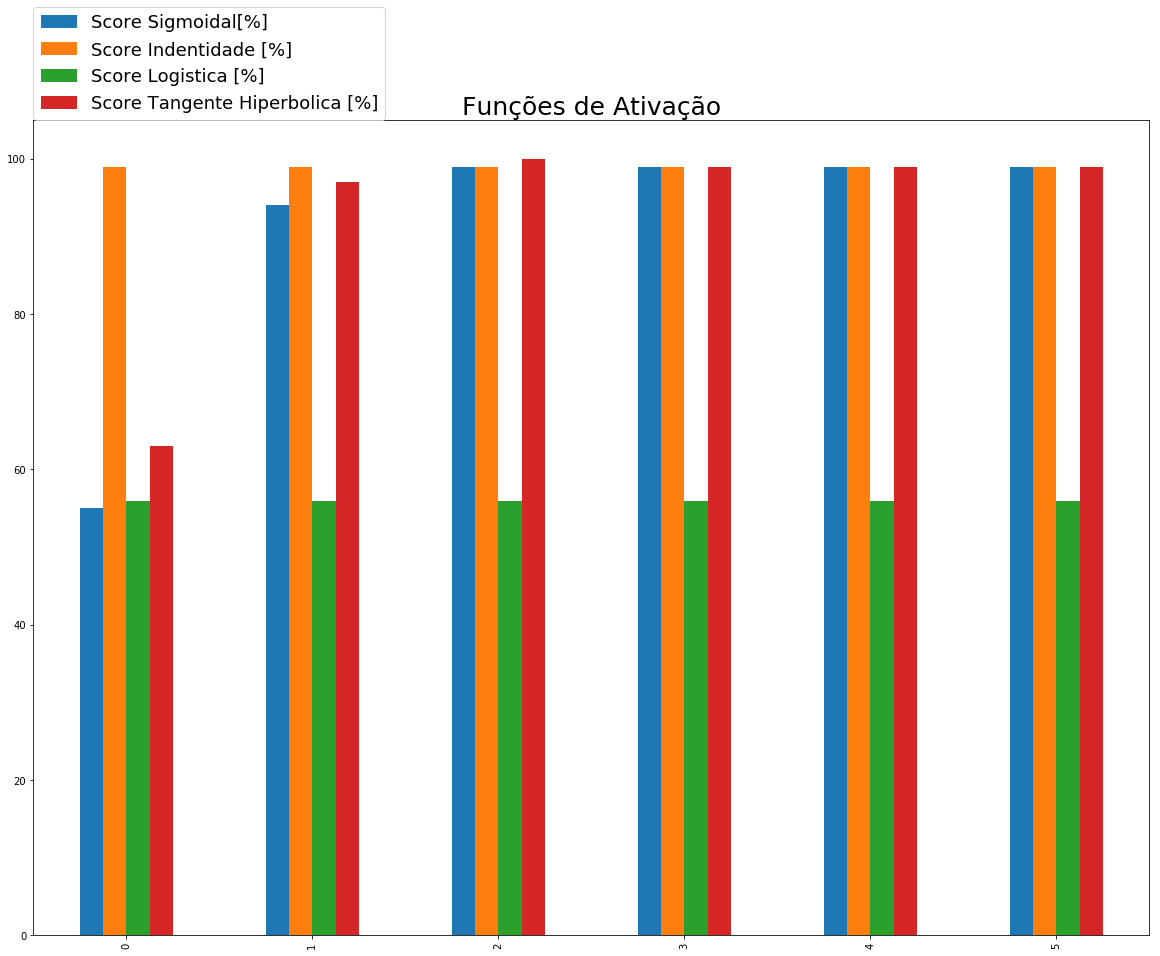

In [96]:
result = []
result_i = []
result_l = []
result_t =[]
for c in configs:
    mlp = MLPClassifier(hidden_layer_sizes=c,
                            activation = 'identity', 
                            solver='sgd', 
                            verbose=False, 
                            tol=1e-4, 
                            random_state=32,
                            learning_rate_init=0.001)
    mlp.fit(X_train, y_train)
    score_treino = round(mlp.score(X_train, y_train),2)
    score_test = round(mlp.score(X_test, y_test),2)
    result_i.append(score_test*100)
    
for c in configs:
    mlp = MLPClassifier(hidden_layer_sizes=c,
                            activation = 'logistic', 
                            solver='sgd', 
                            verbose=False, 
                            tol=1e-4, 
                            random_state=32,
                            learning_rate_init=0.001)
    mlp.fit(X_train, y_train)
    score_treino = round(mlp.score(X_train, y_train),2)
    score_test = round(mlp.score(X_test, y_test),2)
    result_l.append(score_test*100)
    
for c in configs:
    mlp = MLPClassifier(hidden_layer_sizes=c,
                            activation = 'tanh', 
                            solver='sgd', 
                            verbose=False, 
                            tol=1e-4, 
                            random_state=32,
                            learning_rate_init=0.001)
    mlp.fit(X_train, y_train)
    score_treino = round(mlp.score(X_train, y_train),2)
    score_test = round(mlp.score(X_test, y_test),2)
    result_t.append(score_test*100)
    
for c in configs:
    result.append([c,
                   configs_values[configs.index(c)],
                   result_i[configs.index(c)],
                   result_l[configs.index(c)],
                   result_t[configs.index(c)]
                  ])

df = pd.DataFrame(result,
                   columns=['Config (layer1,layer2)',
                            'Score Sigmoidal[%]', 
                            'Score Indentidade [%]', 
                            'Score Logistica [%]', 
                            'Score Tangente Hiperbolica [%]'])

ax = df.plot(kind='bar', figsize=(20,15))
ax.legend(loc=(0,1),fontsize=18)
ax.set_title('Funções de Ativação', fontsize=25)
fig = ax.get_figure()
fig.savefig('rn_activations.png')
#ax.get_figure()

C:\bin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
C:\bin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


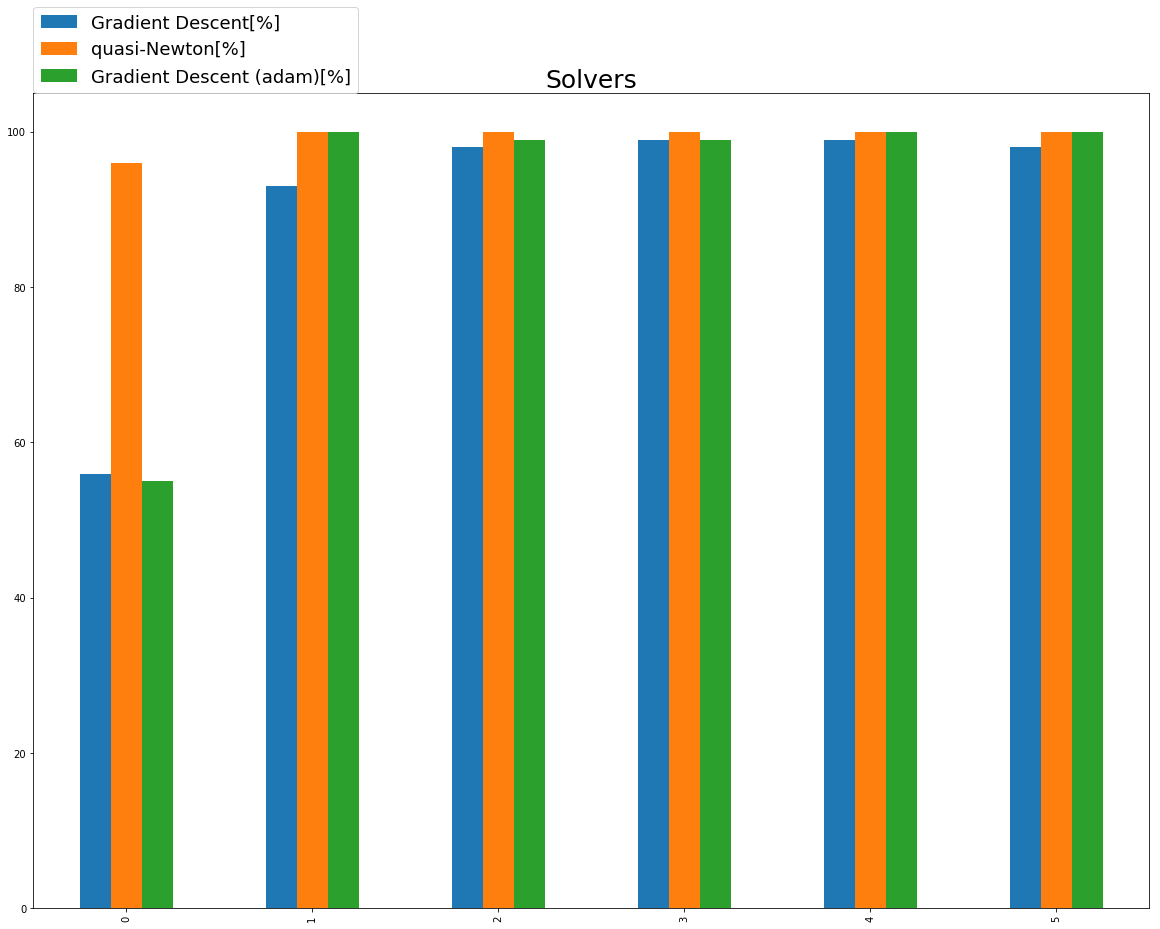

In [97]:
configs = [(1,2),(2,2),(3,4),(2,3),(3,5),(4,4)]
configs_values = [56,93,98,99,99,98]
solvers = ['lbfgs', 'adam']

result = []
result_l = []
result_a = []
for c in configs:
    mlp = MLPClassifier(hidden_layer_sizes=c,
                        activation = 'relu', 
                        solver='lbfgs', 
                        verbose=False, 
                        tol=1e-4, 
                        random_state=32,
                        learning_rate_init=0.001)
    mlp.fit(X_train, y_train)
    score_treino = round(mlp.score(X_train, y_train),2)
    score_test = round(mlp.score(X_test, y_test),2)
    result_l.append(score_test*100)
    
for c in configs:
    mlp = MLPClassifier(hidden_layer_sizes=c,
                        activation = 'relu', 
                        solver='adam', 
                        verbose=False, 
                        tol=1e-4, 
                        random_state=32,
                        learning_rate_init=0.001)
    mlp.fit(X_train, y_train)
    score_treino = round(mlp.score(X_train, y_train),2)
    score_test = round(mlp.score(X_test, y_test),2)
    result_a.append(score_test*100)

for c in configs:
    result.append([c,
                   configs_values[configs.index(c)],
                   result_l[configs.index(c)],
                   result_a[configs.index(c)]
                  ])
    
df = pd.DataFrame(result,
                  columns=['Config (layer1,layer2)',
                           'Gradient Descent[%]', 
                           'quasi-Newton[%]', 
                           'Gradient Descent (adam)[%]'])
ax = df.plot(kind='bar', figsize=(20,15))
ax.legend(loc=(0,1),fontsize=18)
ax.set_title('Solvers', fontsize=25)
fig = ax.get_figure()
fig.savefig('rn_solvers.png')
ax.get_figure()

C:\bin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


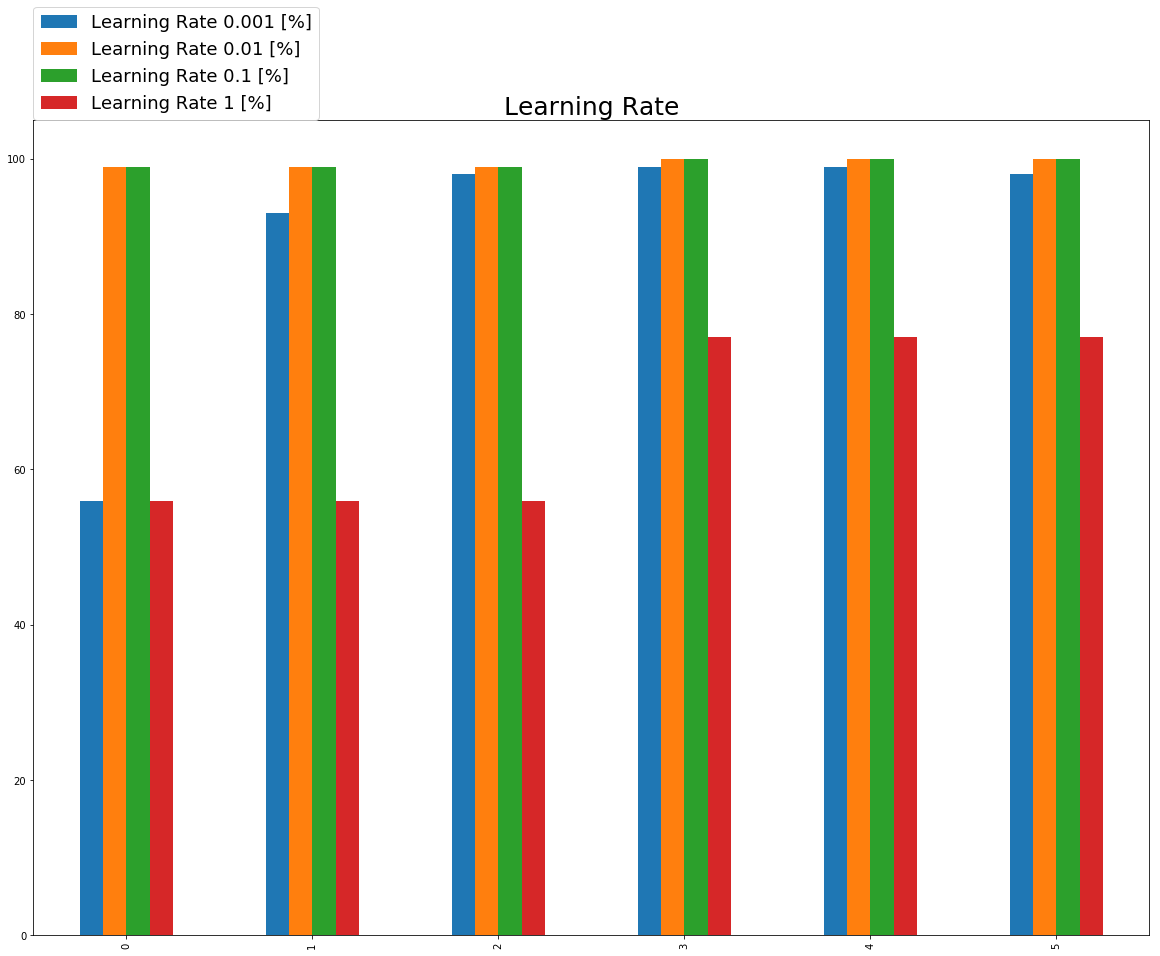

In [99]:
configs = [(1,2),(2,2),(3,4),(2,3),(3,5),(4,4)]
configs_values = [56,93,98,99,99,98]
rates = [0.01, 0.1, 1]

result = []
result_001 = []
result_01 = []
result_1 = []
for c in configs:
    for r in rates:
        mlp = MLPClassifier(hidden_layer_sizes=c,
                            activation = 'relu', 
                            solver='sgd', 
                            verbose=False, 
                            tol=1e-4, 
                            random_state=32,
                            learning_rate_init=0.01)
        mlp.fit(X_train, y_train)
        score_treino = round(mlp.score(X_train, y_train),2)
        score_test = round(mlp.score(X_test, y_test),2)
        result_001.append(score_test*100)
        
for c in configs:
    for r in rates:
        mlp = MLPClassifier(hidden_layer_sizes=c,
                            activation = 'relu', 
                            solver='sgd', 
                            verbose=False, 
                            tol=1e-4, 
                            random_state=32,
                            learning_rate_init=0.1)
        mlp.fit(X_train, y_train)
        score_treino = round(mlp.score(X_train, y_train),2)
        score_test = round(mlp.score(X_test, y_test),2)
        result_01.append(score_test*100)
        
for c in configs:
    for r in rates:
        mlp = MLPClassifier(hidden_layer_sizes=c,
                            activation = 'relu', 
                            solver='sgd', 
                            verbose=False, 
                            tol=1e-4, 
                            random_state=32,
                            learning_rate_init=1)
        mlp.fit(X_train, y_train)
        score_treino = round(mlp.score(X_train, y_train),2)
        score_test = round(mlp.score(X_test, y_test),2)
        result_1.append(score_test*100)
        
for c in configs:
    result.append([c,
                   configs_values[configs.index(c)],
                   result_001[configs.index(c)],
                   result_01[configs.index(c)],
                   result_1[configs.index(c)]
                  ])
        
df = pd.DataFrame(result,
             columns=['Config (layer1,layer2)',
                      'Learning Rate 0.001 [%]', 
                      'Learning Rate 0.01 [%]',
                      'Learning Rate 0.1 [%]',
                      'Learning Rate 1 [%]'])

ax = df.plot(kind='bar', figsize=(20,15))
ax.legend(loc=(0,1),fontsize=18)
ax.set_title('Learning Rate', fontsize=25)
fig = ax.get_figure()
fig.savefig('rn_learning_rate.png')
ax.get_figure()

In [ ]:
# mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=400, alpha=1e-4,
#                     solver='sgd', verbose=10, tol=1e-4, random_state=1)
#hidden_layer_size - todos os layers tem a mesma quantidade de neuronios e sao todos interligados a tupla diz quantos layers e quantos neuronios cada
#max_iter - maximo de iteracoes
#solver - funcao utilizada para atribuir os pesos. sgd = stochastic gradient descendent
#learning_rate - valor constante atribuido para atualização dos pesos. é o tamanho do passo
#tol - limiar tolerancia. Quando duas geracoes nao melhora por pelo menos o valor de tol, a rede para de rodar
#random_state = seed para randomo numbers
mlp = MLPClassifier(hidden_layer_sizes=(1,1), max_iter=50,
                    solver='sgd', verbose=0, tol=1e-4, random_state=53,
                    learning_rate_init=0.001)

mlp.fit(X_train, y_train)
print("Training set score: {}".format(mlp.score(X_train, y_train)))
print("Test set score: {}".format(mlp.score(X_test, y_test)))
score_treino = round(mlp.score(X_train, y_train),2)
score_test = round(mlp.score(X_test, y_test),2)

print('ACERTOU: {}% | ERROU: {}%'.format(mlp.score(X_test, y_test)*100,100 - mlp.score(X_test, y_test)*100))
#plt.show()
## Gráfico da função perda para o classificador já treinado:
f = plt.figure(figsize=(9,9))
plt.suptitle('Perda durante o GD\nlayer1 {} | layer2 {} | iter {} | l_rate {}\nscore_treino {} | score_test{}'.format(1,2,50,0.001, score_treino, score_test), fontsize=20)
plt.plot(mlp.loss_curve_)
f.savefig('loss-gd1.png')
plt.show()

In [ ]:
# mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=400, alpha=1e-4,
#                     solver='sgd', verbose=10, tol=1e-4, random_state=1)
#hidden_layer_size - todos os layers tem a mesma quantidade de neuronios e sao todos interligados a tupla diz quantos layers e quantos neuronios cada
#max_iter - maximo de iteracoes
#solver - funcao utilizada para atribuir os pesos. sgd = stochastic gradient descendent
#learning_rate - valor constante atribuido para atualização dos pesos. é o tamanho do passo
#tol - limiar tolerancia. Quando duas geracoes nao melhora por pelo menos o valor de tol, a rede para de rodar
#random_state = seed para randomo numbers
mlp = MLPClassifier(hidden_layer_sizes=(1,2), max_iter=50,
                    solver='sgd', verbose=0, tol=1e-4, random_state=53,
                    learning_rate_init=1)

mlp.fit(X_train, y_train)
print("Training set score: {}".format(mlp.score(X_train, y_train)))
print("Test set score: {}".format(mlp.score(X_test, y_test)))
score_treino = round(mlp.score(X_train, y_train),2)
score_test = round(mlp.score(X_test, y_test),2)

print('ACERTOU: {}% | ERROU: {}%'.format(mlp.score(X_test, y_test)*100,100 - mlp.score(X_test, y_test)*100))
#plt.show()
## Gráfico da função perda para o classificador já treinado:
f = plt.figure(figsize=(9,9))
plt.suptitle('Perda durante o GD\nlayer1 {} | layer2 {} | iter {} | l_rate {}\nscore_treino {} | score_test {}'.format(1,2,50,1, score_treino, score_test), fontsize=20)
plt.plot(mlp.loss_curve_)
f.savefig('loss-gd2.png')
plt.show()

In [ ]:
range_layers = 6
range_neurons = 10
iterations = 100
learning_rate = 0.001

result = []
mlps = []
f, axarr = plt.subplots(range_layers, 3)
f.set_size_inches(45, 45, forward=True)
f.subplots_adjust(hspace=0.5)
for l in range(1,range_layers+1):
    mlp_aux = None
    for n in range(0,range_neurons+1):
        mlp = train_rn(X_train,y_train,l,n,iterations,learning_rate)
        score_treino = round(mlp.score(X_train, y_train),2)
        #result.append([l,n,mlp.n_iter_,score_treino])
        result.append([l,n,score_treino])
        score_teste = round(mlp.score(X_test, y_test),2)
        
        if(n%3==0):
            axarr[l-1, int(n/3)-1].plot(mlp.loss_curve_, "r-")
            axarr[l-1, int(n/3)-1].set_title('layers1 {} | layer2 {} \n score_treino {} |score_teste {}'.format(l,n,score_treino,score_teste), fontsize=45)
        
        
        if(mlp_aux is None):
            mlp_aux = mlp
        elif(mlp.n_iter_ < mlp_aux.n_iter_):
            mlp_aux = mlp
    mlps.append(mlp_aux)
f.savefig('loss-cost-full.png')
plt.show()

In [ ]:
#cols = ['layer1', 'layer2', 'max_iter', 'accuracy']
cols = ['layer1', 'layer2', 'accuracy']
pd.DataFrame(result, columns=cols)
plt.plot(result)